# Modelos 1

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [49]:
df=pd.read_csv("reservaciones_clean.csv")
df.drop(columns="Cliente_Disp",inplace=True)
df.head()

,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,ID_Paquete,ID_Segmento_Comp,ID_Agencia,ID_empresa,ID_Tipo_Habitacion,ID_canal,h_fec_lld_ok,h_fec_sda_ok,Reservacion,ID_estatus_reservaciones,h_can_res,h_cod_reserva,h_edo,h_codigop,h_tfa_total
0,2,2,0,3,1,1,14,112,1,25,10,2019-11-07,2019-11-10,1,9,9,31047,85,333,2659.98
1,4,4,0,4,1,2,14,112,1,25,10,2019-12-01,2019-12-05,1,9,9,31047,54,398,1764.00
2,2,2,0,4,1,1,14,112,1,23,10,2019-12-01,2019-12-05,1,9,9,31047,75,6566,2660.04
3,4,3,0,3,1,2,14,112,1,24,10,2019-12-08,2019-12-11,1,9,9,31047,54,2961,1995.03
4,2,2,0,4,1,1,5,14,1,4,13,2019-12-08,2019-12-12,1,9,12,23266,85,1224,13369.92


In [50]:
df['h_fec_lld_ok']=pd.to_datetime(df['h_fec_lld_ok'])
df['h_fec_sda_ok']=pd.to_datetime(df['h_fec_sda_ok'])
df['h_fec_sda_ok']=df['h_fec_sda_ok'].astype('int64')/1e9
df=df.sort_values('h_fec_lld_ok')

In [51]:
df2=df.copy()
df2=df2[['h_fec_lld_ok','h_tfa_total']]
df2=df2.groupby('h_fec_lld_ok').sum().reset_index()

Text(0.5, 0, 'h_fec_lld_ok')

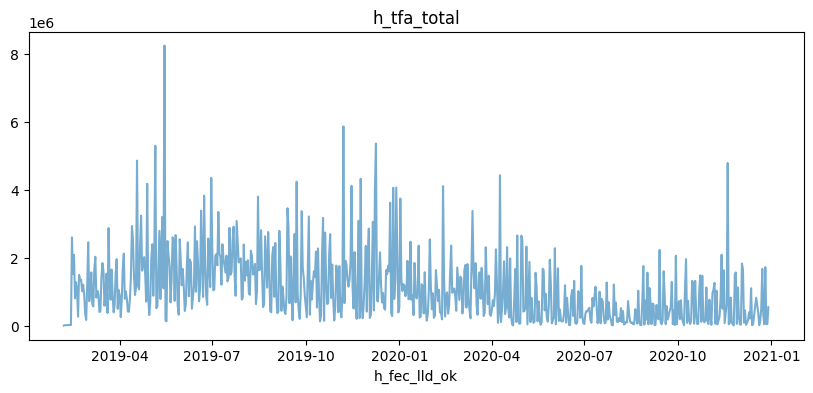

In [52]:
plt.figure(figsize=(10, 4))
plt.plot(df2['h_fec_lld_ok'], df2['h_tfa_total'], linestyle='-', alpha=0.6)
plt.title('h_tfa_total')
plt.xlabel('h_fec_lld_ok')

## Suavizado

In [53]:
from scipy.signal import savgol_filter
df2['smoothed'] = df2['h_tfa_total'].rolling(window=7).mean() #media movil simple
df2['smoothed2'] = df2['h_tfa_total'].ewm(span=7, adjust=False).mean() # Suavizado exponencial
df2['smoothed3'] = savgol_filter(df2['h_tfa_total'], window_length=15, polyorder=2)

Text(0.5, 0, 'Fecha')

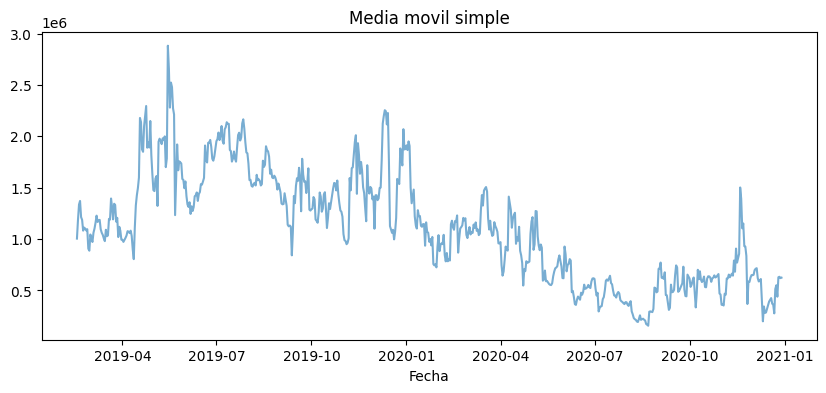

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(df2['h_fec_lld_ok'], df2['smoothed'], linestyle='-', alpha=0.6)
plt.title('Media movil simple')
plt.xlabel('Fecha')

Text(0.5, 0, 'Fecha')

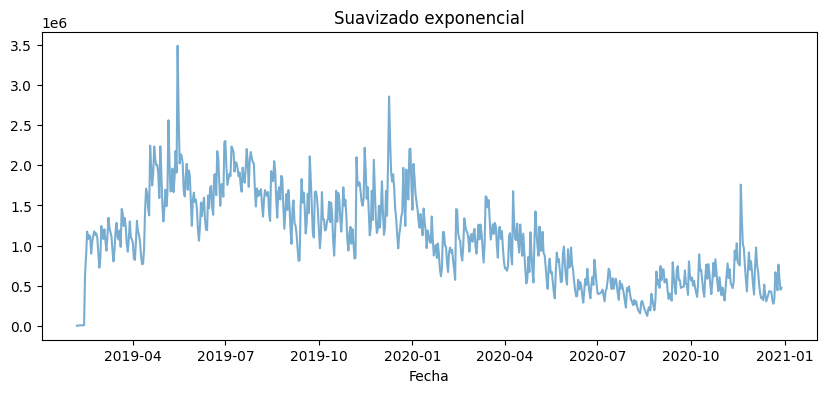

In [55]:
plt.figure(figsize=(10, 4))
plt.plot(df2['h_fec_lld_ok'], df2['smoothed2'], linestyle='-', alpha=0.6)
plt.title('Suavizado exponencial')
plt.xlabel('Fecha')

Text(0.5, 0, 'Fecha')

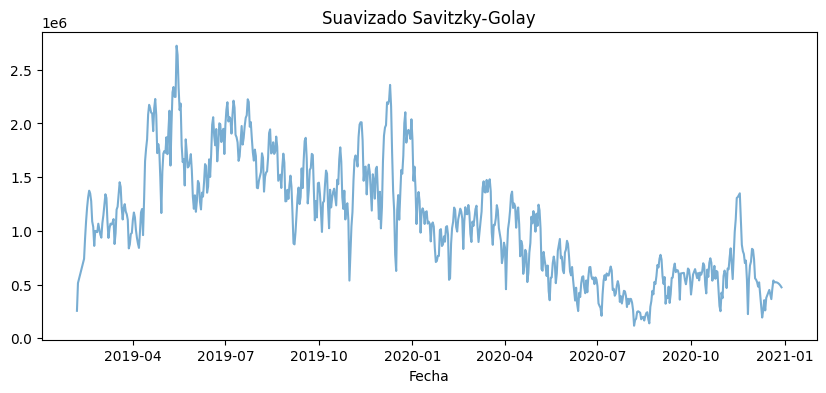

In [56]:
plt.figure(figsize=(10, 4))
plt.plot(df2['h_fec_lld_ok'], df2['smoothed3'], linestyle='-', alpha=0.6)
plt.title('Suavizado Savitzky-Golay')
plt.xlabel('Fecha')

<Axes: >

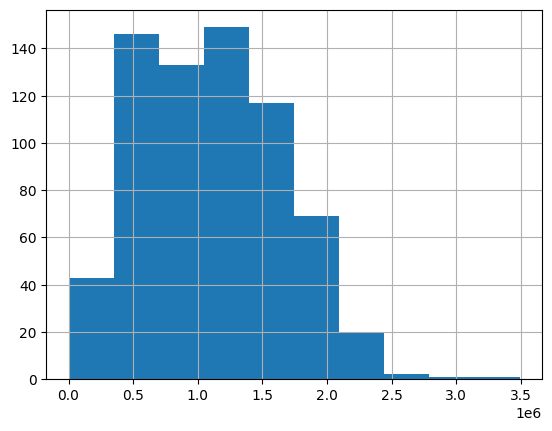

In [57]:
## Distribucion del suavizado exponencial
df2['smoothed2'].hist()

In [ ]:
#Prueba de normalidad de los datos
from scipy import stats
shapiro_test = stats.shapiro(df2['smoothed2'])
shapiro_test

ShapiroResult(statistic=np.float64(0.9760117689922364), pvalue=np.float64(3.991409785508688e-09))

## LSTM

In [59]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


In [60]:
df2.set_index("h_fec_lld_ok", inplace=True)

In [61]:
df_lstm=df2[["smoothed2"]]

In [18]:
if shapiro_test.pvalue < 0.05:
    print("Distribución NO normal → Usando MinMaxScaler")
    scaler = MinMaxScaler()
else:
    print("Distribución normal → Usando StandardScaler")
    scaler = StandardScaler()

# Escalado de datos
scaled_data = scaler.fit_transform(df_lstm)

Distribución NO normal → Usando MinMaxScaler


In [19]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [20]:
window_size = 30
X, y = create_sequences(scaled_data, window_size)

In [21]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ajustar forma para LSTM 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# def modelo_lstm(units=128, activation='relu', dropout_rate=0.2):
#     model = Sequential()
#     model.add(Input(shape=(window_size, 1)))
#     # Primera capa LSTM
#     model.add(LSTM(units, activation=activation, return_sequences=True, input_shape=(window_size, 1)))
#     model.add(Dropout(dropout_rate))

#     # Segunda capa LSTM (retorna secuencias para alimentar a la siguiente)
#     model.add(LSTM(units, activation=activation, return_sequences=True))
#     model.add(Dropout(dropout_rate))

#     # Tercera capa LSTM (última, puede devolver sólo el último estado)
#     model.add(LSTM(units, activation=activation))
#     model.add(Dropout(dropout_rate))

#     # Capa de salida
#     model.add(Dense(1))

#     # Compilación
#     #model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
#     #model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',  metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()])
#     model.compile(optimizer='adam', loss='mean_squared_error')

#     return model

In [26]:
def modelo_lstm(units=128, activation='relu', dropout_rate=0.2, learning_rate=0.001):
    '''
    Crea un modelo LSTM con tres capas LSTM y Dropout entre ellas para evitar sobreajuste.
    
    - Entrada: secuencias de longitud window_size con 1 feature.
    - Salida: capa densa para predicción continua (regresión).
    - Compilado con optimizador Adam y pérdida MSE.

    Retorna:
    - Modelo LSTM compilado listo para entrenar.
    '''
    model = Sequential()
    model.add(Input(shape=(window_size, 1)))

    model.add(LSTM(units, activation=activation, return_sequences=True, input_shape=(window_size, 1)))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units, activation=activation, return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units, activation=activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    #model.compile(optimizer=Adam(learning_rate=learning_rate), loss=['mse', 'mape'])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', 'mape']
        )

    return model

In [24]:
# Wrap con KerasRegressor
model_lstm = KerasRegressor(model=modelo_lstm, verbose=0)


In [ ]:
#Parametros que se utilizaran en el GridSearch
# param_grid_lstm = {
#     'model__units': [32, 64, 128],
#     'model__activation': ['relu', 'tanh'],
#     'model__dropout_rate': [0.1, 0.2],
#     'epochs': [5, 10],
# }
# param_grid_lstm = {
#     'model__units': [32],
#     'model__activation': ['relu'],
#     'model__dropout_rate': [0.01],
#     'model__learning_rate': [0.001],
#     'epochs': [50],
# }

In [25]:
# GridSearch
# grid_lstm = GridSearchCV(estimator=model_lstm, param_grid=param_grid_lstm , cv=2)
# grid_result_lstm = grid_lstm.fit(X_train, y_train)

### Graficas elaboradas con los paramentros obtenidos al correr model_lstm.py

In [ ]:
params = {
    "activation": "tanh",
    "dropout_rate": 0.01,
    "learning_rate": 0.001,
    "units": 64
}
epochs=100
final_model=modelo_lstm(**params)

c:\Users\gersa\OneDrive\Escritorio\tca_proyecto\lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# y_pred = grid_result_lstm.best_estimator_.predict(X_test)

In [ ]:
# best_params = grid_result_lstm.best_params_
# model_params = {
#     'units': best_params['model__units'],
#     'activation': best_params['model__activation'],
#     'dropout_rate': best_params['model__dropout_rate'],
#     'learning_rate': best_params['model__learning_rate']
# }
# epochs = best_params['epochs']


# final_model = modelo_lstm(**model_params)

c:\Users\gersa\OneDrive\Escritorio\tca_proyecto\lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###  Revisar con X_test y y_test

In [ ]:
history = final_model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=1
    )

# Evaluar el modelo en el test set
loss = final_model.evaluate(X_test, y_test)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0588 - mae: 0.1904 - mape: 57.0892 - val_loss: 0.0092 - val_mae: 0.0822 - val_mape: 72.3145
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0111 - mae: 0.0849 - mape: 35.3239 - val_loss: 0.0086 - val_mae: 0.0790 - val_mape: 68.6843
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0094 - mae: 0.0782 - mape: 30.4876 - val_loss: 0.0055 - val_mae: 0.0599 - val_mape: 50.1432
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0094 - mae: 0.0740 - mape: 26.2450 - val_loss: 0.0041 - val_mae: 0.0480 - val_mape: 34.8199
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0090 - mae: 0.0715 - mape: 24.3916 - val_loss: 0.0042 - val_mae: 0.0471 - val_mape: 30.9750
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0096 - mae: 0.0729 - mape: 23.7100 - val_loss: 0.0041 - val_mae: 0.0470 - val_mape: 31.3765
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0079 - mae: 0.

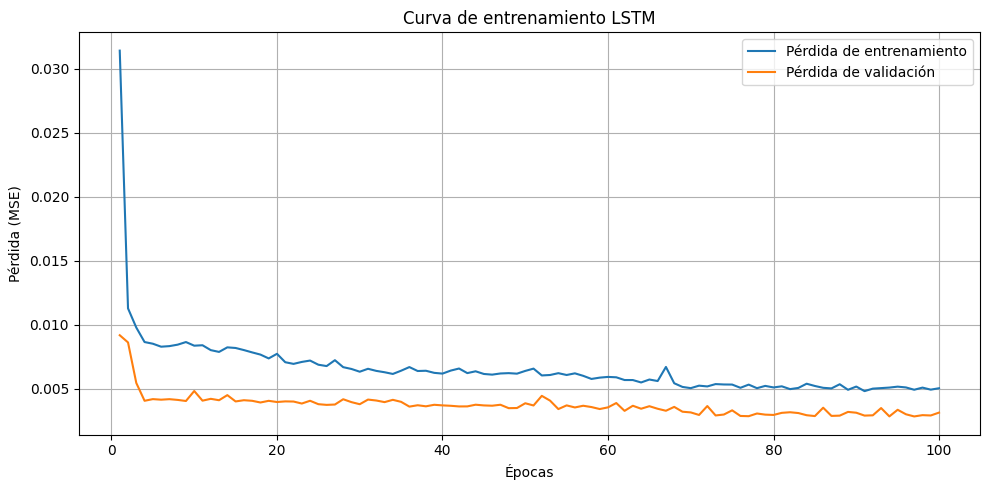

In [ ]:

# Graficar la perdida
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Curva de entrenamiento LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
# Hacer predicciones
y_pred = final_model.predict(X_test)
#y_pred = grid_result_lstm.best_estimator_.predict(X_test)
# Invertir escalamiento si usaste MinMaxScaler
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


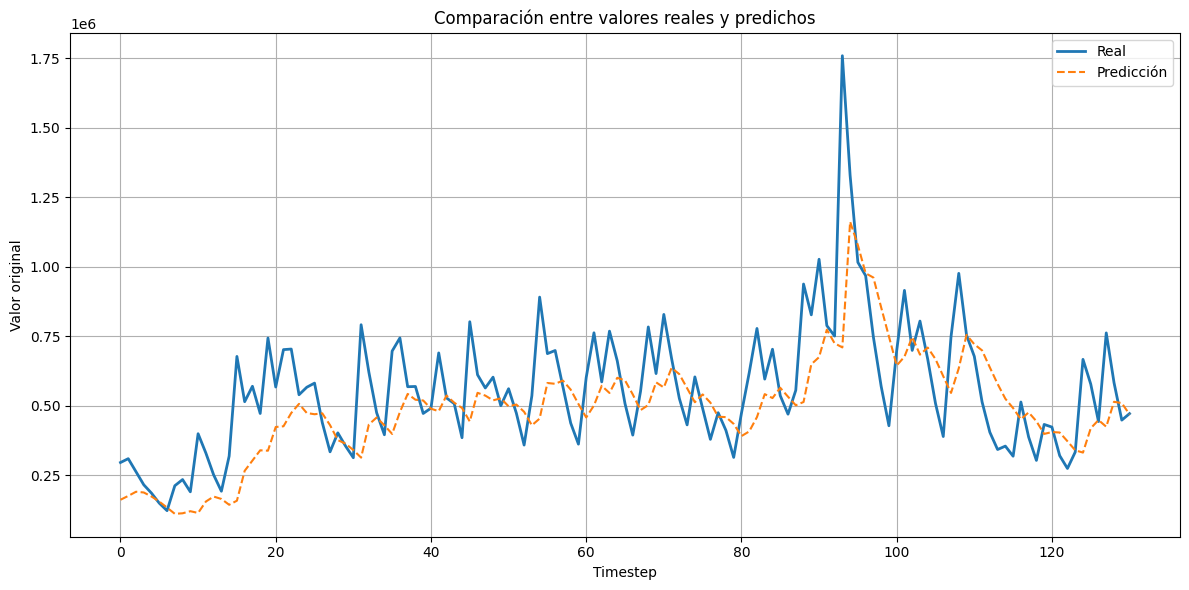

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Real', linewidth=2)
plt.plot(y_pred_inv, label='Predicción', linestyle='--')
plt.title('Comparación entre valores reales y predichos')
plt.xlabel('Timestep')
plt.ylabel('Valor original')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Predicciones

In [ ]:
import numpy as np

def predict_future(model, last_sequence, n_steps, scaler=None):
    """
    Predice n pasos futuros con un modelo LSTM ya entrenado.

    Parámetros:
    - model: modelo LSTM ya entrenado
    - last_sequence: último fragmento de la serie escalada con shape (window_size, 1)
    - n_steps: número de pasos a predecir
    - scaler: (opcional) objeto MinMaxScaler para desescalar las predicciones

    Retorna:
    - lista de predicciones (en escala original si se proporciona scaler)
    """
    predictions = []
    input_seq = last_sequence.copy()

    for _ in range(n_steps):
        pred = model.predict(input_seq.reshape(1, *input_seq.shape), verbose=0)
        predictions.append(pred[0, 0])
        
        # Desliza la ventana
        input_seq = np.append(input_seq[1:], [[pred[0, 0]]], axis=0)

    # revertir escalado
    if scaler:
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    return predictions


In [ ]:
# Última secuencia conocida escalada
last_sequence = scaled_data[-window_size:] 

# Predecir 14 dias futuros
future_preds = predict_future(final_model, last_sequence, n_steps=14, scaler=scaler)
print(future_preds)

[455982.75 441022.25 424910.06 406568.4  387178.53 367528.4  348154.56
 328273.25 308565.47 290474.94 273643.5  258217.1  243829.69 230091.4 ]


In [67]:
df_lstm.index = pd.to_datetime(df_lstm.index)

In [ ]:



# Genera fechas futuras a partir del último índice
n_steps = len(future_preds)
last_date = df_lstm.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(1, unit='D'), periods=n_steps, freq='D')

# Crear serie con predicciones
future_series = pd.Series(future_preds, index=future_dates)

# Combinar ambas
combined_series = pd.concat([df_lstm, future_series])



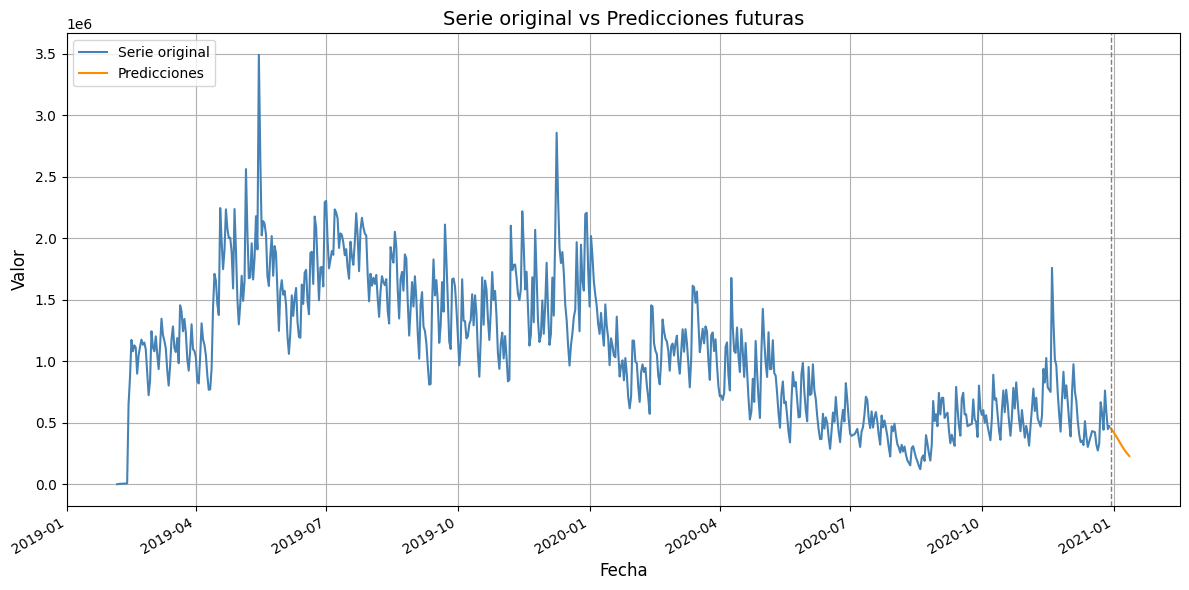

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Gráfica de la serie original
df_lstm['smoothed2'].plot(label='Serie original', color='steelblue')

# Gráfica de predicciones
future_series.plot(label='Predicciones', color='darkorange')

# Línea vertical que separa lo observado de lo predicho
plt.axvline(x=future_series.index[0], color='gray', linestyle='--', linewidth=1)


plt.title("Serie original vs Predicciones futuras", fontsize=14)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
